In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
#from scipy.interpolate import RBFInterpolator
from src.RBFInterpolator import RBFInterpolator
import numpy as np
import numpy.typing as npt
from typing import Tuple, Optional, List
from time import perf_counter

PROCESSED = Path('Processed', 'all')
LANDMASK_PATH = Path("landmask_01d.nc")
START_DATE = 5
DATE_INTERVAL = 3
FILES = [Path(f'2005_10_{i}.nc') for i in range(START_DATE, START_DATE + DATE_INTERVAL)]
FIGSIZE = (10, 3)
CMAP = 'jet'

# Load and display data

In [2]:
LANDMASK = xr.open_dataset(LANDMASK_PATH)
datasets = [xr.open_dataset(PROCESSED / file) for file in FILES]
dataset = xr.concat(datasets, dim=list(datasets[0].dims)[0])

In [3]:
lat = dataset.lat.data
lon = dataset.lon.data
data = dataset.sla.data

# Plotting
vmin = data.min()
vmax = data.max()

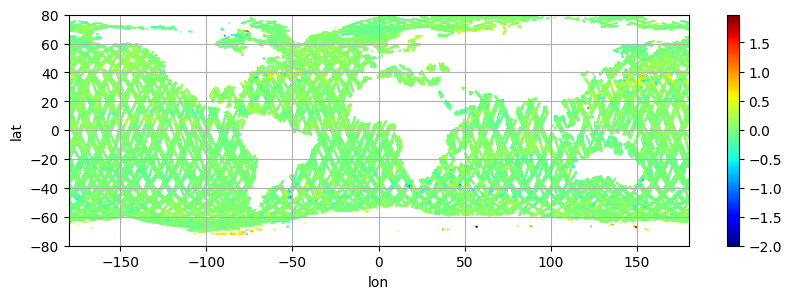

In [4]:
plt.figure(figsize=FIGSIZE)
plt.scatter(lon, lat, c=data, s=0.1, cmap=CMAP, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.grid()
plt.ylim([-80, 80])
plt.xlim([-180, 180])
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

# Grid data

In [5]:
def sign_add(x: float, y: float) -> float:
    """Adds y to x if x<=0 else it subtracts y from x"""
    return x + (y if x <= 0 else -y)
def create_grid(x_deg: float, y_deg: float, x_boundary: Tuple[float, float], y_boundary: Tuple[float, float]) -> List[npt.NDArray[np.float64]]:
    """Creates a grid of x, y"""
    x_start = sign_add(x_boundary[0], x_deg/2)
    x_end = sign_add(x_boundary[1], -x_deg/2)
    x: npt.NDArray[np.float64] = np.arange(x_start, x_end, x_deg)
    y_start = sign_add(y_boundary[0], y_deg/2)
    y_end = sign_add(y_boundary[1], -y_deg/2)
    y: npt.NDArray[np.float64] = np.arange(y_start, y_end, y_deg)
    return np.meshgrid(x, y)

def _landmask_coord_bool(landmask: xr.DataArray | npt.NDArray[np.float64], value: float) -> int:
    """Masks the landmask coordinate by value"""
    bool_arr =  np.where(landmask > value)[0]
    if len(bool_arr) == 0:
        if landmask[0] > value:
            return 0
        return len(landmask)
    return bool_arr[0]

def subset_landmask(landmask: xr.Dataset, x_boundary: Tuple[float, float], y_boundary: Tuple[float, float]) -> xr.Dataset:
    """ Takes a subset of the landmask based on the x and y boundaries"""
    lat_min = _landmask_coord_bool(landmask.lat, y_boundary[0])
    lat_max = _landmask_coord_bool(landmask.lat, y_boundary[1])
    lon_min = _landmask_coord_bool(landmask.lon, x_boundary[0])
    lon_max = _landmask_coord_bool(landmask.lon, x_boundary[1])
    return landmask.isel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max))

In [6]:
def plot_grid(
    x_grid: npt.NDArray[np.float64],
    y_grid: npt.NDArray[np.float64],
    grid: npt.NDArray[np.float64],
    landmask: npt.NDArray[np.float64],
    lon_boundary: Optional[Tuple[float, float]] = None,
    lat_boundary: Optional[Tuple[float, float]] = None,
    points_lon: Optional[npt.NDArray[np.float64]] = None,
    points_lat: Optional[npt.NDArray[np.float64]] = None,
    figsize: Tuple[float, float] = (10, 3),
    cmap: str = "jet",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    blocking: bool = True,
    title: Optional[str] = None
) -> None:
    # Input handling
    if lon_boundary is None:
        lon_boundary = (x_grid[0,:].min(), x_grid[0,:].max())
    if lat_boundary is None:
        lat_boundary = (y_grid[:,0].min(), y_grid[:,0].max())
    
    c_vmin = grid.min() if vmin is None else vmin
    c_vmax = grid.max() if vmax is None else vmax
    
    # Landmask
    land_masked_grid = grid * landmask

    # Get lat, lon boundary indexes
    lat_idx = [_landmask_coord_bool(y_grid[:,0], lb) for lb in lat_boundary]
    lon_idx = [_landmask_coord_bool(x_grid[0,:], lb) for lb in lon_boundary]

    # Extent of the grid
    extent = [*lon_boundary, *lat_boundary]

    # Valid points in the choosen boundary
    points_in_zone: npt.NDArray[np.bool_] | None = None
    if points_lon is not None and points_lat is not None:
        points_in_zone = (
            (points_lon >= extent[0])
            & (points_lon <= extent[1])
            & (points_lat >= extent[2])
            & (points_lat <= extent[3])
        )
    
    # Plot
    fig = plt.figure(figsize=figsize)
    plt.imshow(land_masked_grid[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]], extent=extent, origin='lower', vmin=c_vmin, vmax=c_vmax, cmap=cmap)
    plt.colorbar()
    if points_lon is not None and points_lat is not None and points_in_zone is not None:
        plt.scatter(points_lon[points_in_zone], points_lat[points_in_zone], s=1, color=(0,0,0,0.01))
    plt.xlim(lon_boundary)
    plt.ylim(lat_boundary)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    if title is not None:
        plt.title(title)
    plt.show(block=blocking)

In [7]:
X_RESOLUTION = 1
Y_RESOLUTION = 1
X_BOUNDARY = (-180, 180)
Y_BOUNDARY = (-70, 70)

# Construct grid
x_grid, y_grid = create_grid(X_RESOLUTION, Y_RESOLUTION, X_BOUNDARY, Y_BOUNDARY)
grid_lonlat = np.vstack([x_grid.flatten(), y_grid.flatten()]).T

# Save lon, lat in one matrix
lonlat = np.vstack([lon, lat]).T

# Land mask within the same size as the grid
landmask_grid = subset_landmask(LANDMASK, X_BOUNDARY, Y_BOUNDARY)

## Interpolation methods

### RBF

In [8]:
kernels = ["linear"]
distances = ["euclidean"]

In [10]:
f = {}
y = {}
for kernel in kernels:
    f[kernel] = {}
    y[kernel] = {}
    for distance in distances:
        start = perf_counter()
        f[kernel][distance] = RBFInterpolator(lonlat, data, neighbors=100, kernel=kernel, distance=distance)
        y[kernel][distance] = f[kernel][distance](grid_lonlat).reshape(x_grid.shape)
        print(f"{kernel} - {distance}: {perf_counter() - start:.2f}")

c:\Users\Casper\source\AltimeterGridding\src\_rbfinterp.py:65: RuntimeWarning: invalid value encountered in power
  out[i] = np.prod(x**powers[i])


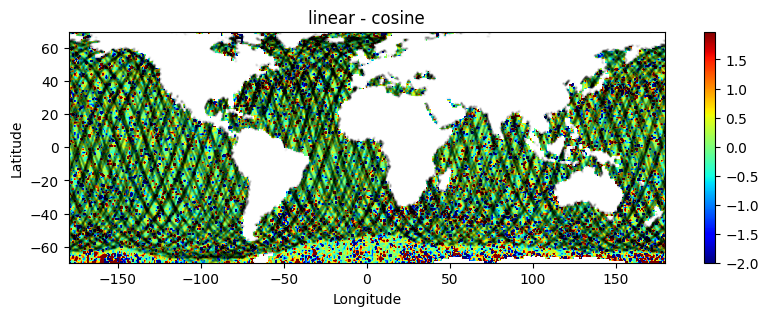

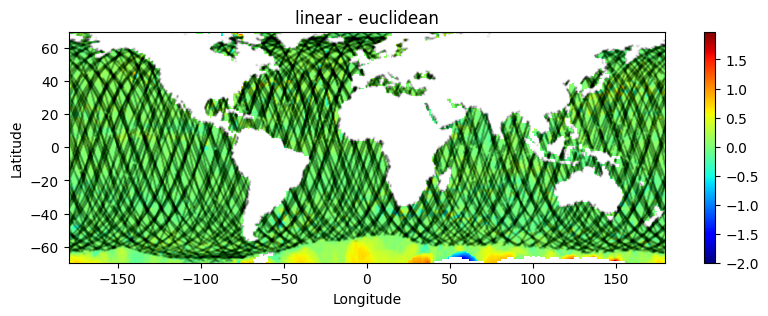

In [13]:
for kernel in kernels:
    if kernel not in y:
        continue
    for distance in distances:
        if distance not in y[kernel]:
            continue
        plot_grid(x_grid=x_grid, y_grid=y_grid, grid=y[kernel][distance], landmask=landmask_grid.z.data, points_lon=lon, points_lat=lat, figsize=FIGSIZE, cmap=CMAP, vmax=vmax, vmin=vmin, title=f"{kernel} - {distance}")

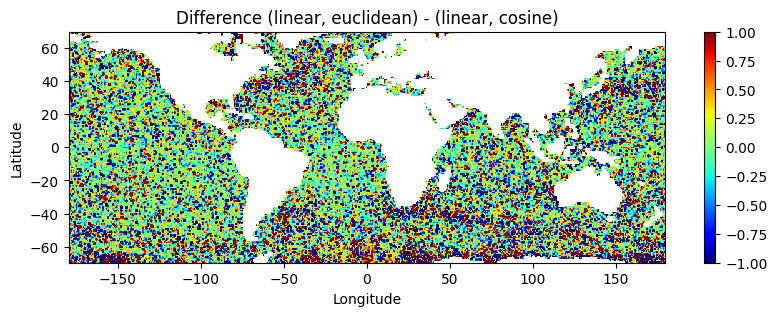

In [17]:
plot_grid(x_grid=x_grid, y_grid=y_grid, grid=y["linear"]["euclidean"] - y["linear"]["cosine"], landmask=landmask_grid.z.data, figsize=FIGSIZE, cmap=CMAP, title=f"Difference (linear, euclidean) - (linear, cosine)", vmin=-1, vmax=1)

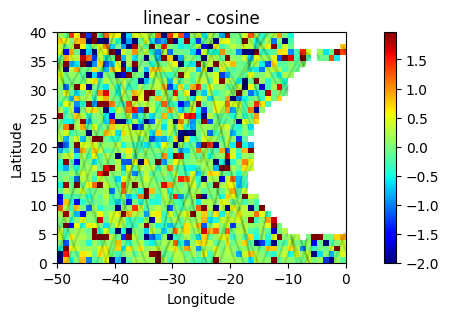

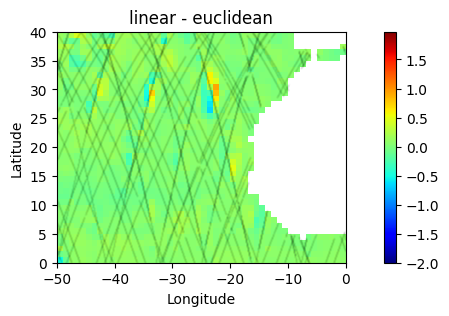

In [18]:
lat_boundary = (0, 40)
lon_boundary = (-50, 0)
for kernel in kernels:
    for distance in distances:
        plot_grid(x_grid=x_grid, y_grid=y_grid, grid=y[kernel][distance], landmask=landmask_grid.z.data, lat_boundary=lat_boundary, lon_boundary=lon_boundary, points_lon=lon, points_lat=lat, figsize=FIGSIZE, cmap=CMAP, vmax=vmax, vmin=vmin, title=f"{kernel} - {distance}")